# Sentiment Embeddings Model Evaluation

This notebook loads the archived sentiment model and evaluates it on the test set. Metrics and visualizations are saved to the evaluation directory.

In [13]:
# Setup: imports and paths
import sys
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.insert(0, str(Path('../../utils').resolve()))
from utils.paths import CACHE_PATH, ROOT_PATH

EVAL_DIR = ROOT_PATH / 'evaluation/sentiment_embeddings'
ARCHIVE_PATH = ROOT_PATH / 'models/sentiment_embeddings.zip'
CACHE_DIR = CACHE_PATH / 'models/sentiment_embeddings'
SPLITS_PATH = ROOT_PATH / 'outputs/sentiment_embeddings/preprocessing/splits.json'

sys.path.insert(0, str(EVAL_DIR))
from eval_utils import compute_metrics
from model_utils import load_model_and_tokenizer, load_test_dataset
from unpack_model import unpack_model

In [14]:
# Unpack model to cache dir (if needed)
unpack_model(ARCHIVE_PATH, CACHE_DIR)
# Load test set and labels using data_utils (matches training notebook)
from data_utils import load_test_dataframe
test_df = load_test_dataframe()
labels = ["neg", "pos"]

In [15]:
# Load model and tokenizer from the correct subdirectory containing config.json with model_type
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os, json
def find_hf_model_dir(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'config.json' in filenames:
            config_path = os.path.join(dirpath, 'config.json')
            with open(config_path, 'r', encoding='utf-8') as f:
                config = json.load(f)
            if 'model_type' in config:
                return dirpath
    raise FileNotFoundError('No valid Hugging Face model directory found.')

model_dir = find_hf_model_dir(CACHE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model.eval()
device = 'cuda' if hasattr(model, 'to') and callable(getattr(model, 'to', None)) and torch.cuda.is_available() else 'cpu'
model.to(device)

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 284.84it/s, Materializing param=pre_classifier.weight]                                  


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [18]:
# Run inference with progress logging
import sys
all_preds, all_labels = [], []
n = len(test_df)
print(f"Running inference on {n} samples...")
with torch.no_grad():
    for i, (_, row) in enumerate(test_df.iterrows()):
        if i % 100 == 0 or i == n - 1:
            print(f"Sample {i+1}/{n}", flush=True)
        inputs = tokenizer(row['text'], return_tensors='pt', truncation=True, padding=True).to(device)
        logits = model(**inputs).logits.cpu().numpy()[0]
        pred = np.argmax(logits)
        all_preds.append(pred)
        all_labels.append(row['sentiment_value'])
all_preds, all_labels = np.array(all_preds), np.array(all_labels)

Running inference on 25000 samples...
Sample 1/25000
Sample 101/25000
Sample 201/25000
Sample 301/25000
Sample 401/25000
Sample 501/25000
Sample 601/25000
Sample 701/25000
Sample 801/25000
Sample 901/25000
Sample 1001/25000
Sample 1101/25000
Sample 1201/25000
Sample 1301/25000
Sample 1401/25000
Sample 1501/25000
Sample 1601/25000
Sample 1701/25000
Sample 1801/25000
Sample 1901/25000
Sample 2001/25000
Sample 2101/25000
Sample 2201/25000
Sample 2301/25000
Sample 2401/25000
Sample 2501/25000
Sample 2601/25000
Sample 2701/25000
Sample 2801/25000
Sample 2901/25000
Sample 3001/25000
Sample 3101/25000
Sample 3201/25000
Sample 3301/25000
Sample 3401/25000
Sample 3501/25000
Sample 3601/25000
Sample 3701/25000
Sample 3801/25000
Sample 3901/25000
Sample 4001/25000
Sample 4101/25000
Sample 4201/25000
Sample 4301/25000
Sample 4401/25000
Sample 4501/25000
Sample 4601/25000
Sample 4701/25000
Sample 4801/25000
Sample 4901/25000
Sample 5001/25000
Sample 5101/25000
Sample 5201/25000
Sample 5301/25000
Sa

In [30]:
np.concat([all_preds.reshape(-1, 1), all_labels.reshape(-1, 1)], axis=1)

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [0, 0],
       [1, 0],
       [0, 0]], shape=(25000, 2))

In [19]:
# Compute and save metrics
metrics = compute_metrics(all_labels, all_preds, labels)
with open(EVAL_DIR / 'metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2)
metrics

{'accuracy': 0.92664,
 'f1_macro': 0.9266380768612021,
 'confusion_matrix': [[11647, 853], [981, 11519]],
 'classification_report': {'neg': {'precision': 0.9223154893886601,
   'recall': 0.93176,
   'f1-score': 0.9270136899076727,
   'support': 12500.0},
  'pos': {'precision': 0.9310539928871646,
   'recall': 0.92152,
   'f1-score': 0.9262624638147314,
   'support': 12500.0},
  'accuracy': 0.92664,
  'macro avg': {'precision': 0.9266847411379124,
   'recall': 0.92664,
   'f1-score': 0.9266380768612021,
   'support': 25000.0},
  'weighted avg': {'precision': 0.9266847411379125,
   'recall': 0.92664,
   'f1-score': 0.9266380768612021,
   'support': 25000.0}}}

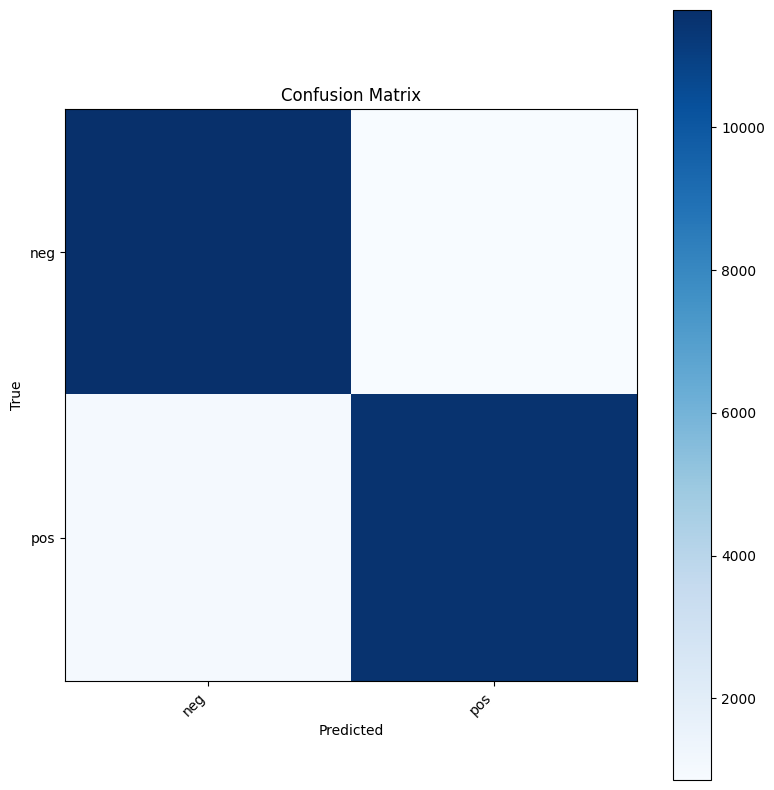

In [20]:
# Visualize confusion matrix
cm = np.array(metrics['confusion_matrix'])
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar(im)
plt.tight_layout()
plt.savefig(EVAL_DIR / 'confusion_matrix.png')
plt.show()

## Results
- Metrics are saved to `metrics.json` in the evaluation directory.
- Confusion matrix is saved as `confusion_matrix.png`.
- See the classification report in the metrics output above.